In [1]:
import os
import pickle
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm

import matplotlib.pyplot as plt

from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset

import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer, HashingVectorizer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [38]:
X = []
y = []
DIR = './gdrive/MyDrive/datasets/'
IMG_DIR = './gdrive/MyDrive/images/'
BATCH_SIZE = 128
NUM_CLASSES = 3
NUM_EPOCH = 30
NUM_FEATURES = 300
LAYER_MAP = {
    300 : 320,
    1000 : 1024,
    2000 : 1984,
    3000 : 3008,
    4000 : 3968
}

In [5]:
try:
    with open('./gdrive/MyDrive/datasets/merged_dataset_X.npy', 'rb') as f:
        X = np.load(f)
    with open('./gdrive/MyDrive/datasets/merged_dataset_y.npy', 'rb') as f:
        y = np.load(f)
except IOError:
    print('file load failed!')

In [ ]:
X[:5]

array([' Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing',
       ' Drunk Bragging Trump Staffer Started Russian Collusion Investigation',
       ' Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’',
       ' Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)',
       ' Pope Francis Just Called Out Donald Trump During His Christmas Speech'],
      dtype='<U305')

In [6]:
def vectorize(X_train, X_test, vectorizer):
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    print(X_train_vec.shape)
    return X_train_vec, X_test_vec, vectorizer.idf_.shape[0]

In [7]:
class TfIdfDataset(Dataset):
    def __init__(self, data, labels):
        self.labels = np.array(labels).astype(np.int)
        self.data = np.array(data).astype(np.float)
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        X = self.data[index]
        y = self.labels[index]
        return X, y

In [8]:
def save_pickle_file(filename, data):
    try:
        with open(os.path.join(DIR, filename), 'wb') as f:
            pickle.dump(data, f)
        print(f'file: {os.path.join(DIR, filename)} save successful!')
    except IOError:
        print(f'file: {os.path.join(DIR, filename)} save unsuccessful!')

In [9]:
def load_pickle_file(filename):
    data = None
    try:
        with open(os.path.join(DIR, filename), 'rb') as f:
            data = pickle.load(f)
            return data
    except IOError:
        print(f'file: {os.path.join(DIR,filename)} load failed!')

In [10]:
def save_and_load_dense_vector(X, y, vectorizer, vectorizer_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)
    print(f"train X: {len(X_train)} train y: {len(y_train)}")
    print(f"test X: {len(X_test)} test y: {len(y_test)}")

    X_train_vec, X_test_vec, num_features = vectorize(X_train, X_test, vectorizer)
    save_pickle_file(f'{vectorizer_name}_X_train_{num_features}.pkl', X_train_vec)
    save_pickle_file(f'{vectorizer_name}_X_test_{num_features}.pkl', X_test_vec)

    save_pickle_file('y_train.pkl', y_train)
    save_pickle_file('y_test.pkl', y_test)

    X_train_vec = X_train_vec.toarray()
    X_test_vec = X_test_vec.toarray()
    
    #save_pickle_file(f'{vectorizer_name}_X_train_{num_features}_dense.pkl', X_train_vec)
    #save_pickle_file(f'{vectorizer_name}_X_test_{num_features}_dense.pkl', X_test_vec)

    #X_train_vec = load_pickle_file(f'{vectorizer_name}_X_train_{num_features}_dense.pkl')
    #X_test_vec = load_pickle_file(f'{vectorizer_name}_X_test_{num_features}_dense.pkl')

    #y_train = load_pickle_file('y_train.pkl')
    #y_test = load_pickle_file('y_test.pkl')
    return X_train_vec, X_test_vec, y_train, y_test

In [11]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [12]:
gpu_name = torch.cuda.get_device_name(0)
print("Using GPU", gpu_name)

Using GPU Tesla T4


In [13]:
def create_dataloaders(X_train_vec, y_train, X_test_vec, y_test):
    train_dataset = TfIdfDataset(X_train_vec, y_train)
    test_dataset = TfIdfDataset(X_test_vec, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, pin_memory=True)
    validation_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, pin_memory=True)
    return train_loader, validation_loader

In [34]:
import torch.nn as nn
import torch.nn.functional as F


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class Unit(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(Unit,self).__init__()
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm1d(num_features=out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)
        return output


class Net(nn.Module):
    def __init__(self, num_classes=3, no_features=2000): #don't forget to change back to 25!
        super(Net, self).__init__()

        self.cnn = nn.Sequential(
            Unit(in_channels=1, out_channels=32, stride=1),
            Unit(in_channels=32, out_channels=32, stride=1),
            Unit(in_channels=32, out_channels=64, stride=1),
            nn.MaxPool1d(2),

            Unit(in_channels=64, out_channels=64, stride=1),
            Unit(in_channels=64, out_channels=64, stride=1),
            Unit(in_channels=64, out_channels=128, stride=1),
            nn.MaxPool1d(2),

            Unit(in_channels=128, out_channels=128, stride=2),
            Unit(in_channels=128, out_channels=128, stride=2),
            Unit(in_channels=128, out_channels=64, stride=2),
            nn.MaxPool1d(2),
            Flatten())

        self.fc = nn.Sequential(
            nn.Linear(LAYER_MAP[no_features], 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, num_classes))

    def forward(self, inputs):
        output = self.cnn(inputs)
        output = self.fc(output)
        scores = F.log_softmax(output, dim=-1)
        return scores

In [15]:
import torch
import torchvision
import multiprocessing as mp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
# from dataset import MyDataset
# from model import MyModel


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train(train_loader, validation_loader, no_features):
    my_model = Net(num_classes=NUM_CLASSES, no_features=no_features)
    my_model = my_model.cuda().float()

    optimizer = torch.optim.SGD(my_model.parameters(), lr=0.005, momentum=0.9, nesterov=True)
    loss_func = torch.nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=400,
                                  threshold=2e-1, verbose=True, min_lr=1e-5)

    print("start training")
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    max_val_acc = 0 #done by student
    final_model = None
    for epoch in range(NUM_EPOCH):
        total = 0
        correct = 0
        my_model.train()
        train_loss = 0
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()
            labels = data[1].cuda()
            input = data[0].cuda().float()
            
            #adding a deimension for matching the shape (batch, number channels, H, W)
            input = input.unsqueeze(1)
            prediction = my_model(input)

            loss = loss_func(prediction, labels)
            train_loss += loss #for calculating the train loss
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

            _, predicted = torch.max(prediction, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            print('[epoch: %5d/%5d, batch: %5d] loss: %.3f, lr: %.10f, acc %d %%'
                  % (epoch, NUM_EPOCH, i, loss.clone().item(), get_lr(optimizer), accuracy))
        train_acc_list.append((100 * correct / total))
        train_loss_list.append(train_loss / total)
        # validation accuracy
        total = 0
        correct = 0
        my_model.eval()

        val_loss = 0
        with torch.no_grad():
            for i, data in enumerate(validation_loader, 0):
                labels = data[1].cuda()
                input = data[0].cuda().float()
                input = input.unsqueeze(1)
                prediction = my_model(input)
                
                loss = loss_func(prediction, labels)
                val_loss += loss

                _, predicted = torch.max(prediction, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('[epoch: %5d/%5d] validation acc %d %%'
              % (epoch, NUM_EPOCH, (100 * correct / total)))
        val_acc_list.append((100 * correct / total))
        val_loss_list.append(val_loss / total)
        #done by student
        val_acc = int(100 * correct / total)
        if val_acc > max_val_acc:
          max_val_acc = val_acc
          final_model = my_model
    torch.save(final_model.state_dict(), os.path.join(DIR, f"my_model_{datetime.now().strftime('%b-%d-%Y-%H-%M-%S')}_{max_val_acc}.pt"))
    return train_acc_list, val_acc_list, train_loss_list, val_loss_list

In [16]:
def plot_train_val_acc_graph(train_acc_list, val_acc_list, feature_name, stop_words=True, save=True):
    x = np.arange(0, NUM_EPOCH)
    plt.plot(x, train_acc_list, label="train accuracy")

    plt.plot(x, val_acc_list, label="val accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy %")
    plt.title(f"Train & Val Accuracy num {feature_name} features:{NUM_FEATURES} Stopwords:{stop_words}")
    plt.legend()

    if save:
        file_name = f'train_val_acc_{feature_name}_{NUM_FEATURES}_stop_{stop_words}.png'
        plt.savefig(os.path.join(IMG_DIR, file_name))
        
    plt.show()

In [17]:
def plot_train_val_loss_graph(train_loss_list, val_loss_list, feature_name, stop_words=True, save=True):
    x = np.arange(0, NUM_EPOCH)
    plt.plot(x, train_loss_list, label="train loss")

    plt.plot(x, val_loss_list, label="val loss")
    plt.xlabel("epochs")
    plt.ylabel("loss %")
    plt.title(f"Train & Val Loss num {feature_name} features:{NUM_FEATURES} Stopwords:{stop_words}")
    plt.legend()

    if save:
        file_name = f'train_val_loss_{feature_name}_{NUM_FEATURES}_stop_{stop_words}.png'
        plt.savefig(os.path.join(IMG_DIR, file_name))
        
    plt.show()

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                            analyzer='word',
                            stop_words=None,
                            token_pattern=r"\b[0-9a-zA-Z]+\b",
                            smooth_idf=True,
                            sublinear_tf=True,
                            max_features=NUM_FEATURES)

hashing_vectorizer = HashingVectorizer(ngram_range=(1,2),
                                analyzer='word',
                                stop_words=stopwords.words('english'),
                                token_pattern=r"(?u)\b\w\w+\b")

In [ ]:
X_train_vec, X_test_vec, y_train, y_test = save_and_load_dense_vector(X, y, tfidf_vectorizer, 'tfidf')

train X: 55118 train y: 55118
test X: 13780 test y: 13780
(55118, 4000)
file: ./gdrive/MyDrive/datasets/tfidf_X_train_4000.pkl save successful!
file: ./gdrive/MyDrive/datasets/tfidf_X_test_4000.pkl save successful!
file: ./gdrive/MyDrive/datasets/y_train.pkl save successful!
file: ./gdrive/MyDrive/datasets/y_test.pkl save successful!


In [ ]:
train_loader, validation_loader = create_dataloaders(X_train_vec, y_train, X_test_vec, y_test)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(Net(num_classes=NUM_CLASSES, no_features=NUM_FEATURES).to(device), torch.Size([1, NUM_FEATURES]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 3000]             128
       BatchNorm1d-2             [-1, 32, 3000]              64
              ReLU-3             [-1, 32, 3000]               0
              Unit-4             [-1, 32, 3000]               0
            Conv1d-5             [-1, 32, 3000]           3,104
       BatchNorm1d-6             [-1, 32, 3000]              64
              ReLU-7             [-1, 32, 3000]               0
              Unit-8             [-1, 32, 3000]               0
            Conv1d-9             [-1, 64, 3000]           6,208
      BatchNorm1d-10             [-1, 64, 3000]             128
             ReLU-11             [-1, 64, 3000]               0
             Unit-12             [-1, 64, 3000]               0
        MaxPool1d-13             [-1, 64, 1500]               0
           Conv1d-14             [-1, 6

start training
[epoch:     0/   10, batch:     0] loss: 1.091, lr: 0.0050000000, acc 40 %
[epoch:     0/   10, batch:     1] loss: 1.095, lr: 0.0050000000, acc 38 %
[epoch:     0/   10, batch:     2] loss: 1.083, lr: 0.0050000000, acc 38 %
[epoch:     0/   10, batch:     3] loss: 1.056, lr: 0.0050000000, acc 41 %
[epoch:     0/   10, batch:     4] loss: 1.028, lr: 0.0050000000, acc 43 %
[epoch:     0/   10, batch:     5] loss: 1.017, lr: 0.0050000000, acc 45 %
[epoch:     0/   10, batch:     6] loss: 1.010, lr: 0.0050000000, acc 46 %
[epoch:     0/   10, batch:     7] loss: 0.988, lr: 0.0050000000, acc 47 %
[epoch:     0/   10, batch:     8] loss: 0.950, lr: 0.0050000000, acc 48 %
[epoch:     0/   10, batch:     9] loss: 1.015, lr: 0.0050000000, acc 48 %
[epoch:     0/   10, batch:    10] loss: 1.000, lr: 0.0050000000, acc 48 %
[epoch:     0/   10, batch:    11] loss: 0.887, lr: 0.0050000000, acc 50 %
[epoch:     0/   10, batch:    12] loss: 0.913, lr: 0.0050000000, acc 50 %
[epoch:   

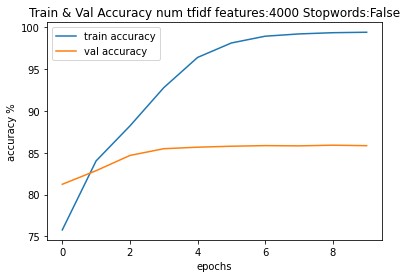

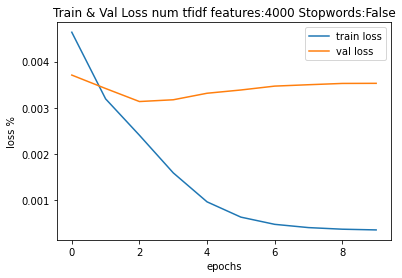

In [ ]:
train_acc_list, val_acc_list, train_loss_list, val_loss_list = train(train_loader, validation_loader, NUM_FEATURES)
plot_train_val_acc_graph(train_acc_list, val_acc_list, 'tfidf', stop_words=False, save=True)
plot_train_val_loss_graph(train_loss_list, val_loss_list, 'tfidf', stop_words=False, save=True)

## Using Word2Vec Data in Neural Network

In [18]:
w2v_X_train = load_pickle_file(os.path.join('word2vecX_train.pkl'))
w2v_X_test = load_pickle_file(os.path.join('word2vecX_test.pkl'))

In [19]:
w2v_X_train.shape

(55118, 300)

In [23]:
y_train = load_pickle_file(os.path.join('y_train.pkl'))
y_test = load_pickle_file(os.path.join('y_test.pkl'))

In [24]:
class W2VDataset(Dataset):
    def __init__(self, data, labels):
        self.labels = np.array(labels).astype(np.int)
        self.data = np.array(data).astype(np.float)
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        X = self.data[index]
        y = self.labels[index]
        return X, y

In [26]:
train_dataset = W2VDataset(w2v_X_train, y_train)
test_dataset = W2VDataset(w2v_X_test, y_test)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, pin_memory=True)
validation_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, pin_memory=True)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(Net(num_classes=NUM_CLASSES, no_features=300).to(device), torch.Size([1, 300]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 300]             128
       BatchNorm1d-2              [-1, 32, 300]              64
              ReLU-3              [-1, 32, 300]               0
              Unit-4              [-1, 32, 300]               0
            Conv1d-5              [-1, 32, 300]           3,104
       BatchNorm1d-6              [-1, 32, 300]              64
              ReLU-7              [-1, 32, 300]               0
              Unit-8              [-1, 32, 300]               0
            Conv1d-9              [-1, 64, 300]           6,208
      BatchNorm1d-10              [-1, 64, 300]             128
             ReLU-11              [-1, 64, 300]               0
             Unit-12              [-1, 64, 300]               0
        MaxPool1d-13              [-1, 64, 150]               0
           Conv1d-14              [-1, 

Streaming output truncated to the last 5000 lines.
[epoch:    18/   30, batch:   184] loss: 0.923, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   185] loss: 0.882, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   186] loss: 0.997, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   187] loss: 1.003, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   188] loss: 0.970, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   189] loss: 0.879, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   190] loss: 0.970, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   191] loss: 0.914, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   192] loss: 0.921, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   193] loss: 0.901, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   194] loss: 0.927, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   195] loss: 0.974, lr: 0.0000100000, acc 53 %
[epoch:    18/   30, batch:   196] loss: 0.922, l

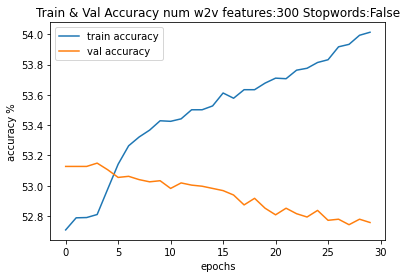

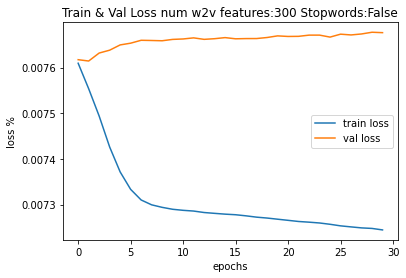

In [39]:
train_acc_list, val_acc_list, train_loss_list, val_loss_list = train(train_loader, validation_loader, 300)
plot_train_val_acc_graph(train_acc_list, val_acc_list, 'w2v', stop_words=False, save=True)
plot_train_val_loss_graph(train_loss_list, val_loss_list, 'w2v', stop_words=False, save=True)